# Technical Test
To run my models, run all cell's with RUN written in

In [0]:
### RUN ###
#Mount google drive, then:
#imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import math
import torch
import scipy

import librosa
import librosa.display

Import data frame provided. Noticed row indexes were odd, so set them as row number

In [12]:
### RUN ###
#import dataFrame provided. Column names as given
data = pd.read_pickle('/content/drive/My Drive/Feebris ML Technical Test/labels.pkl')
data.reset_index(drop=True, inplace=True)
data.head(10)

,filename,patient_id,rec_id,ausc_placement,rec_channel,steth_type,start_time,end_time,crackles,wheeze
0,patient0_2he1_placement1_channel2_steth1.wav,0,2he1,1,2,1,4.065,7.237,0,0
1,patient0_2he1_placement1_channel2_steth1.wav,0,2he1,1,2,1,7.237,10.343,0,0
2,patient0_2he1_placement1_channel2_steth1.wav,0,2he1,1,2,1,10.343,13.394,0,0
3,patient0_2he1_placement1_channel2_steth1.wav,0,2he1,1,2,1,13.394,16.579,0,0
4,patient0_2he1_placement1_channel2_steth1.wav,0,2he1,1,2,1,16.579,19.644,0,0
5,patient0_2he1_placement2_channel2_steth1.wav,0,2he1,2,2,1,4.065,7.237,0,0
6,patient0_2he1_placement2_channel2_steth1.wav,0,2he1,2,2,1,7.237,10.343,0,0
7,patient0_2he1_placement2_channel2_steth1.wav,0,2he1,2,2,1,10.343,13.394,0,0
8,patient0_2he1_placement2_channel2_steth1.wav,0,2he1,2,2,1,13.394,16.579,0,0
9,patient0_2he1_placement2_channel2_steth1.wav,0,2he1,2,2,1,16.579,19.644,0,0


In [0]:
#check balance of data for classification (number of healthy, number of wheezy data samples)
data.wheeze.value_counts()

0    3542
1    2105
Name: crackles, dtype: int64

Text(0, 0.5, 'Amp (AU)')

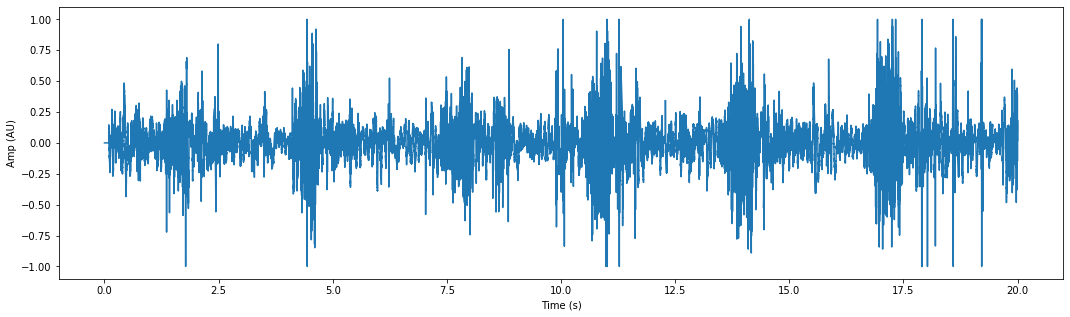

In [0]:
#plot data to get a look at an example recording, sample rate is 44100Hz
t = np.arange(0, 20, 1/44100)
wv = librosa.load('/content/drive/My Drive/Feebris ML Technical Test/data/upload/patient0_2he1_placement1_channel2_steth1.wav', sr=44100)

plt.figure(figsize=(18, 5))
plt.plot(t,wv[0])
plt.xlabel('Time (s)')
plt.ylabel('Amp (AU)')

In [0]:
### RUN ###
# Writing functions for easy of manipulating

#lowpass frequency filter fn, removes frequencies below freq, input time series, returns audio signal in time space
def freq_filt_tt2(wv, freq):
  fft_wv = fftpack.fft(wv)
  sample_freq = fftpack.fftfreq(wv.size, d=1/44100)
  amp = np.abs(fft_wv)

  fft_wv[sample_freq<freq] =0 #using the value give in the pdf
  filt_wv = fftpack.ifft(fft_wv)
  return filt_wv

#fft function, input time series, outputs frequencies and amplitudes
def fft_wv(wv):
  fft_wv = fftpack.fft(wv)
  sample_freq = fftpack.fftfreq(wv.size, d=1/44100)
  amp = np.abs(fft_wv)
  return sample_freq, amp

#select only one breath cycle as defined by start_time and end_time, retunrs time series of one breath cycle
def one_breath_cycle(wv, starttime, endtime):
  return wv[math.ceil(starttime*44100):math.ceil(endtime*44100)]

#loads timeseries on iloc index
def load_wav(index):
  wv = librosa.load('/content/drive/My Drive/Feebris ML Technical Test/data/upload/' + str(data.filename.iloc[index]), sr=44100)
  return wv[0]

#loads timeseries of one breath cycle on iloc index
def load_wav2(index):
  wv = librosa.load('/content/drive/My Drive/Feebris ML Technical Test/data/upload/' + str(data.filename.iloc[index]), sr=44100)
  return one_breath_cycle(wv[0], data.start_time.iloc[index], data.end_time.iloc[index])

#loads timeseries of one breath cycle on iloc index for wheeze dataset (seperately created for test analysis only)
def load_wav2_wheeze(index):
  wv = librosa.load('/content/drive/My Drive/Feebris ML Technical Test/data/upload/' + str(wheeze_dataset.filename.iloc[index]), sr=44100)
  return one_breath_cycle(wv[0], wheeze_dataset.start_time.iloc[index], wheeze_dataset.end_time.iloc[index])

In [0]:
### RUN ###
#loading previously made variables (explained in next two sections)
mfcc_features= np.load('/content/drive/My Drive/mfcc_features3.npy', allow_pickle=True)
mfcc2 = np.load('/content/drive/My Drive/mfcc2.npy')
indexes_to_drop = np.load('/content/drive/My Drive/indexestodrop.npy')
length_mfccs = np.load('/content/drive/My Drive/length_mfcc.npy')

# Investigating Frequency Domain, MFCC
Steps I took to get to grips with librosa's mfcc and deciding what to add into the model.

Note: librosa changes all recordings to mono! So will delete column "steth_type" in dataFrame

Also normalises data!

In [0]:
# Using librosa feature selector to calculate the mfcc of the audio file
y = librosa.feature.mfcc(load_wav2(2), sr=44100, n_mfcc = 40, norm='ortho') #using 40 filterbanks to get higher frequency resolution 

Instructions say dominant frequency can be found between 100 and 1000Hz. Indeed, most of the features are seen in this range. So will keep one dimentional vector that corresonds to that frequency band. Noticed that most mfcc's were of different length as the length of one breath cycle was of variable length. Issue dealt with later.

In [0]:
print(len(y[1,:]))

263


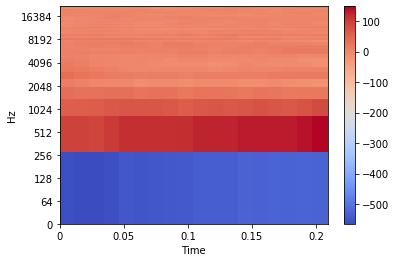

In [0]:
# Visualisation of an MFCC
librosa.display.specshow(y, sr=44100, x_axis='time', y_axis='log')
plt.colorbar()

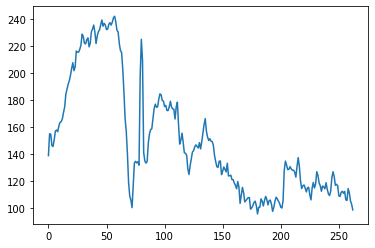

In [0]:
plt.plot(y[1,:])

In [0]:
#Checking for differences with the lower frequency range - relatively small
plt.plot(y[1,:]-y[0,:])

But length of audio input is approx 3*44100, so how big is our window?  Unknown. Should fix it at 300ms say, given that minimum time of wheeze was defined around 250ms (as stated in instructions). In librosa the window is set by fixing win_length, which is equivalent to fixing n_fft as here n_fft = win_length. Set it to 300ms which is 0.3 x 44100 = 13 230. hop length (overlap of different window) is set to default of win_length / 4 . Could change this to win_length/2 but computationally it works so no need, and ensures entirely of wheeze is included. Has no effect on frequency resolution!

In [0]:
#taking new mfcc with window feature included
y2 = librosa.feature.mfcc(load_wav2(1), sr=44100, n_mfcc = 40, n_fft=13230) # where n_fft = window length set at 300ms. 13230 is 300ms* 44100 (sr) norm='ortho',

268


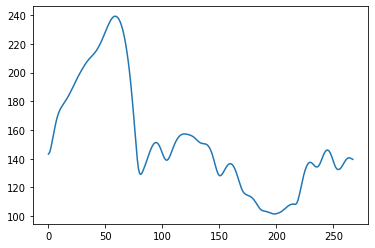

In [0]:
# Gives vector of same length but less noisy than the one above
print(len(y2[1,:]))
plt.plot(y2[1,:])

In [0]:
#To get arrays all of the same length going to padd the arrays with the minimum value. Have not investigated the effect of this yet
y2 = np.pad(y2[1,:], pad_width=(0,300-len(y2[1,:])), mode='minimum')

In [0]:
len(y2[1,:])

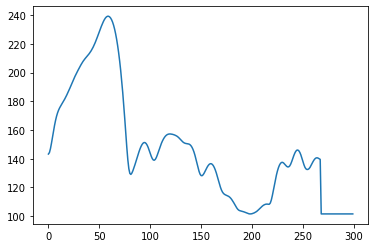

In [0]:
plt.plot(y2);

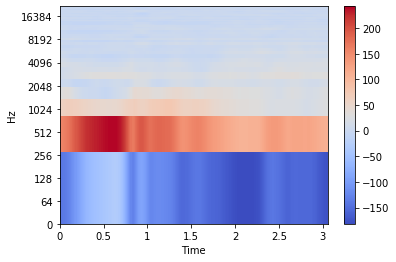

In [0]:
#Looking at the mfcc of the padded array to check effect of padding (checked properly through subtracting y-y2)
librosa.display.specshow(y2, sr=44100, x_axis='time', y_axis='log')
plt.colorbar()

In [0]:
# PREPROCESSING STEP: collect mfcc_features into singe array for the ML stage, using index as identifier
mfcc_features = []

for i in range(0,data.shape[0]): #loop through dataFrame
  y = librosa.feature.mfcc(load_wav2(i), sr=44100, n_mfcc = 40, norm='ortho')
  mfcc_features.append(y[1,:]) #select features in frequency range of wheeze


In [0]:
#np.save('/content/drive/My Drive/mfcc_features3', mfcc_features)
mfcc_features= np.load('/content/drive/My Drive/mfcc_features3.npy', allow_pickle=True)

In [0]:
# wanted to collect single breath cycles for future use - array too large to compute so had to abandon this idea
sbc = []

for i in range(0,data.shape[0]):
  sbc.append(load_wav2(i))

np.save('/content/drive/My Drive/single_breath_cycle', sbc)

Noticed that all "one breath cycle" time series aren't the same length. MFCC's distributed as described below. Big standard deviation, so must have a lot of variation when it comes to the length of a breath recordings in dataset. Some are very short- must be a mistake in the recording so will remove. Else padd/truncate to have vectors of same length for model. This is probably not the best way to do it though as breath length will vary (I assume) for sick/healthy people (but by that much?)

In [0]:
length_mfccs=[]
for i in range(0, len(mfcc_features)):
  length_mfccs.append(len(mfcc_features[i]))

#desciption of the mfcc array properties
pd.Series(length_mfccs).describe()

count    5647.000000
mean      229.722153
std        93.361921
min        18.000000
25%       170.000000
50%       218.000000
75%       288.000000
max       675.000000
dtype: float64

In [0]:
#np.save('/content/drive/My Drive/length_mfcc', length_mfccs)
length_mfccs = np.load('/content/drive/My Drive/length_mfcc.npy')

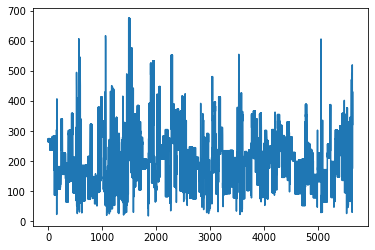

In [0]:
# Plotting the length distribution of the mfcc's - would do this with the length of a breath cycle but not enough computing power
plt.plot(length_mfccs)


In [0]:
# Choosing arbitrary cut off to be 350. Longer mfcc arrays means longer one_breath_cycle recordings, assumed to be too long so recording error
# find number of arrays longer than 340
(np.array(length_mfccs)>340).sum()

631

# Preprocessing

Noticed some of the audio recordings were quite short, so filtering all input data by setting up a limit to make sure only valid recordings are used. Limits are 1.5seconds minimum to 3.5seconds max. Randomly selected and have not investigated if there is an optimum. Other ideas include use 10-90% quartile range? Decide when I have more of an understanding of pnemonia. 

In [0]:
# For each row in data frame (ie for each patient and for each recording position) if the recording is within [1.5-3.5] seconds and the length of the mfcc 
# is less than array_size (*), use the data in the model, else excude. (* this is essentially the same condition twice. Should have done: -> 3.5seconds breath at 44100hz
# is 154 350, mfcc of 154 350 with window length and hop chosen = XXX (to be calculated) to save calculation time. 
# values are chosen by educted guess.

mfcc2=[]
data2=data
array_size=350 #want all mfcc to be 300 long
indexes_to_drop = []

for i in range(0, data.shape[0]):
  y = librosa.feature.mfcc(load_wav2(i), sr=44100, n_mfcc = 40, n_fft=13230)
  if (data.end_time.iloc[i]-data.start_time.iloc[i] >1.5) & (data.end_time.iloc[i]-data.start_time.iloc[i] <3.5) & (len(y[1,:])<(array_size+1)):
    y2 = y[1,:]/max(y[1,:])
    y2 = np.pad(y2, pad_width=(0,array_size-len(y2)), mode='minimum')
    mfcc2.append(y2)
  else: indexes_to_drop.append(i)

In [0]:
# Variables saved and loaded for use
#np.save('/content/drive/My Drive/mfcc2', mfcc2)
#np.save('/content/drive/My Drive/indexestodrop', indexes_to_drop)
mfcc2 = np.load('/content/drive/My Drive/mfcc2.npy')
indexes_to_drop = np.load('/content/drive/My Drive/indexestodrop.npy')

In [0]:
# Breakdown of variables used for checking. 
print(len(data))
print(len(indexes_to_drop))
print('Using {} number of input data points'.format(len(data)-len(indexes_to_drop)))

5647
1934
Using 3713 number of input data points


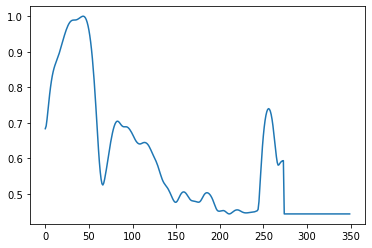

In [0]:
#checking it all worked ok and that the length of the mfcc's is indeed 350
plt.plot(mfcc2[0]);

# ML Bit
output of preprocessing: mfcc2 dataframe with the mfcc features of 3713 audio recordings. Have not included any time domain features, but should! Plan to use extract_features from tsfresh package.

In [0]:
### RUN ###
# Selecting the rows of original data frame that correspond to the rows of the mfcc's using in the model
data2=data.copy();

# selecting the indexes to keep from data. much faster than df.drop()
indexes_to_keep = set(range(data2.shape[0])) - set(indexes_to_drop)
df_sliced = data2.take(list(indexes_to_keep))

df_sliced.set_index(np.arange(0, len(df_sliced)));

In [0]:
### RUN ###
#get classification labels
df_wheeze = df_sliced.wheeze
#df_sliced2 = df_sliced.drop(labels=['filename', 'patient_id', 'rec_id', 'rec_channel', 'start_time', 'end_time', 'wheeze'], axis=1, inplace=True);

# Logistic Regression Model with only MFCC inputs
Using only MFCC's inputs to start with to see effect. Choosing simple Logistic Regression model to begin with.

From here on run all cells



In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

#output2 = label_binarize(outputs, classes=[0,1])

x_train, x_test, y_train, y_test = train_test_split(mfcc2, df_wheeze, test_size=0.33, random_state=11)#, stratify=df_wheeze

In [0]:
# have to change data type or LogisticRegresison doesn't work
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=0.001,random_state=11, max_iter = 1e7, solver='saga') # C is regularisation parameter
model.fit(x_train, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000000.0,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:,1] #get probabilities of each class 

In [0]:
#model.score(y_pred, y_test)

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, f1_score

[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred)) #Not a great metric as out data set isn't split 50/50
print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba)) # 
print(model.__class__.__name__+" f1_score is %2.3f" % f1_score(y_test, y_pred, average='weighted')) # f1 score is 2* precision*sensitivity/(prec.+sens.) 
print(model.__class__.__name__+" precision_score is %2.3f" % precision_score(y_test, y_pred, average='weighted')) # precision score
print(model.__class__.__name__+" recall_score is %2.3f" % recall_score(y_test, y_pred, average='weighted')) # precision score
print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr)) # probably best metric for understanding model

Train/Test split results:
LogisticRegression accuracy is 0.783
LogisticRegression log_loss is 0.518
LogisticRegression f1_score is 0.688
LogisticRegression precision_score is 0.613
LogisticRegression recall_score is 0.783
LogisticRegression auc is 0.619


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Keeping track of Results

**Using precision_score and sensitivity as measures of model.**
Precision is TP/(TP+FP) where TP: true positive, FP: false positive. 
Sensitivity is TP/(TP+FN) where FN: False negative - how many of overall positives does the model detect. 
These measures are complimentary and give a good indication of errors (Precision : amount of incorrectly labeled positives, Sensitivity: amount of missed positives)

Have not done hyperparameter optimisation, this model is just to explore datset with mfcc's -> give hyperparameter optimisation to comet to do. (comet.ml)


With test size 0.33:
```
Train/Test split results:
LogisticRegression precision_score is 0.613
LogisticRegression recall_score is 0.783
```

# Logistic Regression with other inputs

Including the dataFrame inputs like ausc_placement and steth_type. All other variables considered not important to classification.

**Includes ### RUN ### cells**

In [0]:
### RUN ###
df_sliced.reset_index(drop=True, inplace=True) #setting index to row number

dummy_inputs = df_sliced[['ausc_placement', 'steth_type']] #chose only ausc_p and steth_type columns

dummy_inputs = pd.get_dummies(dummy_inputs, columns=['ausc_placement', 'steth_type']) #change them into dummy variables

mfcc_inputs = pd.DataFrame(mfcc2, index=np.arange(0, len(mfcc2))) 
inputs = pd.concat([dummy_inputs, mfcc_inputs], axis=1) #put mfcc's dataframe and dunny inputs together into one big df
#inputs = pd.concat([df_sliced[['ausc_placement', 'steth_type']], mfcc_inputs], axis=1)
input2 = pd.concat([pd.get_dummies(df_sliced.ausc_placement), pd.get_dummies(df_sliced.steth_type), mfcc_inputs], axis=1) #can also do in one step...

In [0]:
### RUN ###
# Do all in one
input2 = pd.concat([pd.get_dummies(df_sliced.ausc_placement), pd.get_dummies(df_sliced.steth_type), mfcc_inputs], axis=1)
input2.head(10);

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

#output2 = label_binarize(outputs, classes=[0,1])

x_train, x_test, y_train, y_test = train_test_split(input2, df_wheeze, test_size=0.33, random_state=11)#, stratify=df_wheeze

y_train = y_train.astype('int')
y_test = y_test.astype('int')

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=0.001,random_state=11, max_iter = 1e7, solver='saga') #lasso penalty for when number of features increased, not that there are a lot of features...
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:,1]

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, f1_score, precision_score

[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(model.__class__.__name__+" f1_score is %2.3f" % f1_score(y_test, y_pred, average='weighted')) # f1 score is 2* precision*sensitivity/(prec.+sens.) 
print(model.__class__.__name__+" precision_score is %2.3f" % precision_score(y_test, y_pred, average='weighted')) # precision score
print(model.__class__.__name__+" recall_score is %2.3f" % recall_score(y_test, y_pred, average='weighted')) # precision score
print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))


Train/Test split results:
LogisticRegression accuracy is 0.783
LogisticRegression log_loss is 0.518
LogisticRegression f1_score is 0.688
LogisticRegression precision_score is 0.613
LogisticRegression recall_score is 0.783
LogisticRegression auc is 0.619


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Changing the test size make a large difference. AUC decreases after 0.33 due to overfitting

```
LogisticRegression precision_score is 0.613
LogisticRegression recall_score is 0.783
```

So extra variables (ausc_placment and steth_type) don't help the performance of the model. (Could have also seen this from weights)

again no hyperparameter optimisation

# LinearSVC
Now using a better model: Support Vector Machine seperates classes by a hyperplane (here using linear kernel). Basic model first.

In [33]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(input2, df_wheeze, test_size=0.33, random_state=11) # stratify=df_wheeze

y_train = y_train.astype('int')
y_test = y_test.astype('int')

model = LinearSVC(random_state=11, tol=1e-6, max_iter=1e6)
model.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000000.0,
          multi_class='ovr', penalty='l2', random_state=11, tol=1e-06,
          verbose=0)

In [35]:
y_pred = model.predict(x_test)

#y_pred_proba = model.predict_proba(x_test)[:,1]

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, f1_score, precision_score; recall_score

#[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
#print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(model.__class__.__name__+" f1_score is %2.3f" % f1_score(y_test, y_pred, average='weighted')) # f1 score is 2* precision*sensitivity/(prec.+sens.) 
print(model.__class__.__name__+" precision_score is %2.3f" % precision_score(y_test, y_pred, average='weighted')) # precision score
print(model.__class__.__name__+" recall_score is %2.3f" % recall_score(y_test, y_pred, average='weighted')) # precision score
#print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))


Train/Test split results:
NuSVC accuracy is 0.780
NuSVC f1_score is 0.696
NuSVC precision_score is 0.700
NuSVC recall_score is 0.780


A much better model, using precision score and recall_score as markers. 

```
Train/Test split results:
LogisticRegression accuracy is 0.781
LogisticRegression log_loss is 0.519
LogisticRegression f1_score is 0.697
LogisticRegression precision_score is 0.705
LogisticRegression recall_score is 0.781
LogisticRegression auc is 0.614
```

# NuSVC

Using NuSVC, a more tunable version of LinearSVC. Can control number of support vectors used to set hyperplane to seperate classes and kernel (linear kernel etc...).

In [21]:
### RUN ### (need to run first two cells in "LogesticRegression with other inputs" section)

from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

x_train, x_test, y_train, y_test = train_test_split(input2, df_wheeze, test_size=0.33, random_state=11)#, stratify=df_wheeze

y_train = y_train.astype('int')
y_test = y_test.astype('int')

model = NuSVC(nu= 0.3, kernel = 'rbf', random_state=11, tol=1e-5, max_iter=-1, decision_function_shape='ovo') #'ovo' is one vs one for classification classes
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

#y_pred_proba = model.predict_proba(x_test)[:,1]

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, f1_score, precision_score; recall_score

print('Train/Test split results:')
print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(model.__class__.__name__+" f1_score is %2.3f" % f1_score(y_test, y_pred, average='weighted')) # f1 score is 2* precision*sensitivity/(prec.+sens.) 
print(model.__class__.__name__+" precision_score is %2.3f" % precision_score(y_test, y_pred, average='weighted')) # precision score
print(model.__class__.__name__+" recall_score is %2.3f" % recall_score(y_test, y_pred, average='weighted')) # sensitivity score (TP/(TP+FN))


Train/Test split results:
NuSVC accuracy is 0.809
NuSVC f1_score is 0.794
NuSVC precision_score is 0.790
NuSVC recall_score is 0.809


Best Results
```
LogisticRegression precision_score is 0.790
LogisticRegression recall_score is 0.809
```

This increases sensitivity and precision of model!

# Exploring important features

In [40]:
print(model.dual_coef_.argmax())
print(model.dual_coef_.max())

768
37.3813041564169




Model performance is coming from mfcc features (found through previous test of removing ausc_placmenet and steth_type). I should include time domain features too, and see if that helps. (extract_features from tsfresh looks like a promising place to start)

# Testing Generalisability of Model

Ideas include:


*   test on audio recordings from a different make of stethoscope with different sampling rate for example - checks adaptability of model
*   add stochastic noise to audio recordings and test threshold for correct classification - checks margin of classifier. 

*   I'm assuming all patients come from a mixed cohort (ages, sexes, lifestyles etc...), if not varying this would test it's generalisability. 







# Future work 
I am curious how a cnn would work. Though of applying a LSTM model, but ran out of time.


Seem to have saturated at value of 0.78 accuracy. To get higher either try new model (cnn) or add more variable in. Adding more variables would require more preprocesing (add other features), so trying out new models first

In [0]:
y_train.shape[0]

Add a dummy dimension? 

In [0]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint


model = Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[0], x_train.shape[1]), return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.summary()



In [0]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(x_train, y_train, epochs=200, batch_size=32, callbacks=[chk])

#loading the model and checking accuracy on the test data
#model = load_model('best_model.pkl')

from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(x_test)
accuracy_score(y_test, test_preds)